MAE: 4.75070203777336
RMSE: 34.25407904115949
R2 Score: 0.9089925434762842


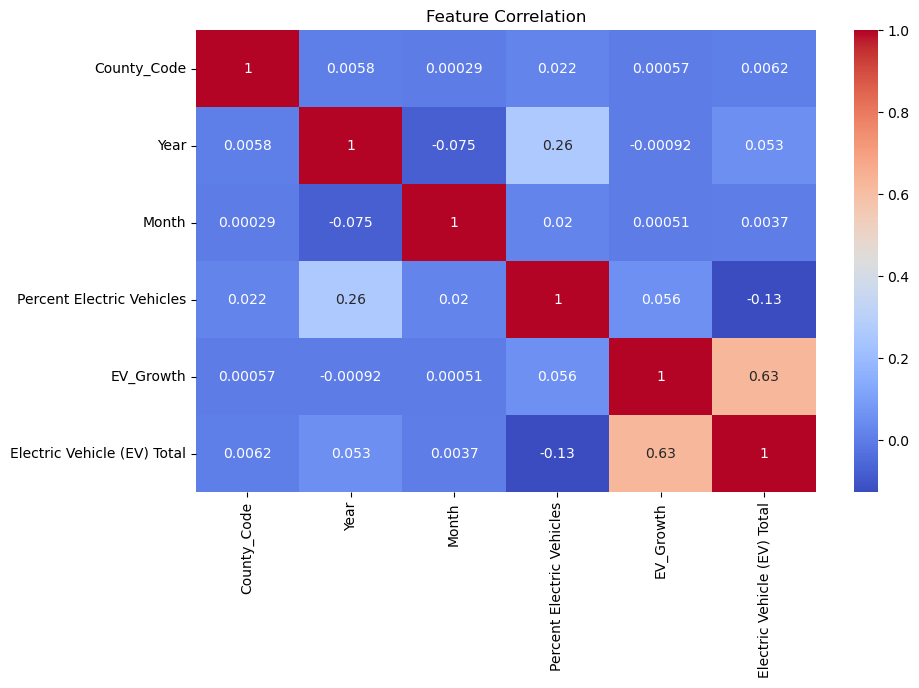

      County  Year  Predicted EVs
17202    Ada  2025          2.180
5773     Ada  2025          2.135
505    Adams  2025         37.900
7941   Adams  2025         23.045
20334  Adams  2025          1.370

📊 Heatmap Explanation:
This heatmap shows how strongly each feature is related to the EV total.
- A value near 1 = strong positive relation (both increase together).
- A value near -1 = strong negative relation (one increases while the other decreases).
- A value near 0 = little to no direct relationship.
This helps us see which factors are useful for prediction.

📈 Model Performance Metrics Explanation:
- MAE (Mean Absolute Error): Average error in predictions. Lower is better.
- RMSE (Root Mean Squared Error): Like MAE but penalizes big errors more. Lower is better.
- R² Score (R-squared): Measures how well the model explains the data.
  - 1.0 means perfect prediction
  - 0.0 means no better than guessing
  - Negative means worse than guessing



In [6]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load dataset
df = pd.read_csv(r"C:\Users\rahul j\Downloads\Electric_Vehicle_Population_By_County.csv")

# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Drop invalid rows
df = df[df['Date'].notnull()]
df = df[df['Electric Vehicle (EV) Total'].notnull()]
df['County'] = df['County'].fillna('Unknown')
df['State'] = df['State'].fillna('Unknown')

# Feature Engineering
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Electric Vehicle (EV) Total'] = pd.to_numeric(df['Electric Vehicle (EV) Total'], errors='coerce')

# Sort and calculate EV Growth
df.sort_values(by=['County', 'Date'], inplace=True)
df['EV_Growth'] = df.groupby('County')['Electric Vehicle (EV) Total'].diff().fillna(0)

# Handle Percent Electric Vehicles outliers
df['Percent Electric Vehicles'] = pd.to_numeric(df['Percent Electric Vehicles'], errors='coerce')
Q1 = df['Percent Electric Vehicles'].quantile(0.25)
Q3 = df['Percent Electric Vehicles'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df['Percent Electric Vehicles'] = np.where(
    df['Percent Electric Vehicles'] > upper_bound, upper_bound,
    np.where(df['Percent Electric Vehicles'] < lower_bound, lower_bound, df['Percent Electric Vehicles'])
)

# Label Encode County
le = LabelEncoder()
df['County_Code'] = le.fit_transform(df['County'])

# Feature selection
features = ['County_Code', 'Year', 'Month', 'Percent Electric Vehicles', 'EV_Growth']
target = 'Electric Vehicle (EV) Total'

# Prepare X and y
X = df[features]
y = pd.to_numeric(df[target], errors='coerce')
X = X[y.notnull()]
y = y[y.notnull()]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Model
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# Predict and Evaluate
y_pred = model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2 Score:", r2_score(y_test, y_pred))

# Correlation Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df[features + [target]].corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation")
plt.show()

# Forecasting next year EV counts
future_df = df[df['Year'] == df['Year'].max()].copy()
future_df['Year'] += 1
future_df['EV_Growth'] = df.groupby('County')['EV_Growth'].transform('mean')
future_X = future_df[features]
future_preds = model.predict(future_X)
future_df['Predicted EVs'] = future_preds

# Show result
print(future_df[['County', 'Year', 'Predicted EVs']].head())

# Explain the correlation heatmap to non-technical users
print("\n📊 Heatmap Explanation:")
print("This heatmap shows how strongly each feature is related to the EV total.")
print("- A value near 1 = strong positive relation (both increase together).")
print("- A value near -1 = strong negative relation (one increases while the other decreases).")
print("- A value near 0 = little to no direct relationship.")
print("This helps us see which factors are useful for prediction.\n")

# Explain model scores in simple terms
print("📈 Model Performance Metrics Explanation:")
print(f"- MAE (Mean Absolute Error): Average error in predictions. Lower is better.")
print(f"- RMSE (Root Mean Squared Error): Like MAE but penalizes big errors more. Lower is better.")
print(f"- R² Score (R-squared): Measures how well the model explains the data.")
print("  - 1.0 means perfect prediction")
print("  - 0.0 means no better than guessing")
print("  - Negative means worse than guessing\n")

